In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rough_bergomi.models import RoughBergomiModel, GBMModel, HestonModel
from rough_bergomi.utils.utils import bs_delta, bsinv, bs  # Black-Scholes inversion for IV calculation
import yfinance as yf
import seaborn as sns

from rough_bergomi.hedging.deep_hedger import DeepHedgerTF

from scipy.stats import skew, kurtosis

In [34]:
model = RoughBergomiModel()
results = []

hidden_size = 64
n_layers = 1
optimizer = 'adam'
loss_types = ['mshe', 'cvar', 'entropic']

for loss in loss_types:
    print(f"Running Deep Hedger with loss: {loss.upper()}")

    dh = DeepHedgerTF(
        model=model,
        M=5000,
        N=100,
        T=1
    )

    dh.prepare_data()
    gamma = 10 if loss == 'entropic' else None

    dh.build_and_compile_model(
        lr=0.001,
        loss_type=loss,
        gru_layers=n_layers,
        hidden_size=hidden_size,
        optimizer=optimizer,
        gamma=gamma
    )

    dh.train_model(epochs=30, batch_size=256)

    hedging_error = dh.evaluate_model()

    # Plot error distribution
    dh.plot_error(loss_type = loss)
    dh.plot_pnl()

        # Statistical metrics
    mean_error = np.mean(hedging_error)
    std_error = np.std(hedging_error)
    cvar_1_error = np.mean(np.sort(hedging_error)[:int(0.01 * len(hedging_error))])
    cvar_5_error = np.mean(np.sort(hedging_error)[:int(0.05 * len(hedging_error))])
    cvar_10_error = np.mean(np.sort(hedging_error)[:int(0.1 * len(hedging_error))])
    skew_error = skew(hedging_error)
    kurt_error = kurtosis(hedging_error, fisher=True)  # Excess kurtosis

    results.append((loss, mean_error, std_error, cvar_1_error, cvar_5_error, cvar_10_error, skew_error, kurt_error))

Running Deep Hedger with loss: MSHE


KeyboardInterrupt: 

In [33]:
# Updated summary table with CVaR at 5% and 10%
for loss, mean_e, std_e, cvar_1, cvar_5, cvar_10, skew_e, kurt_e in results:
    print(f"{loss.upper():<10} | Mean: {mean_e:.4f} | Std: {std_e:.4f} | "
          f"CVaR@1%: {cvar_1:.4f} | CVaR@5%: {cvar_5:.4f} | CVaR@10%: {cvar_10:.4f} | "
          f"Skew: {skew_e:.4f} | Kurtosis: {kurt_e:.4f}")

AttributeError: 'float' object has no attribute 'upper'

Running Deep Hedger with ENTROPIC loss, gamma=0.001
Mean hedging error: 2.948599336580209
Std of hedging error: 49.741034288122165


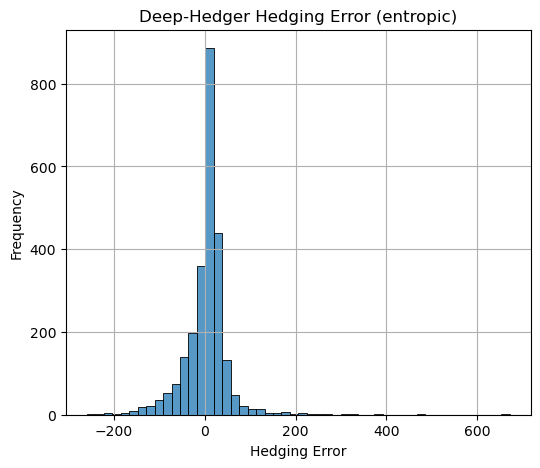

Running Deep Hedger with ENTROPIC loss, gamma=0.01
Mean hedging error: 0.26997441619429424
Std of hedging error: 5.3951140586106145


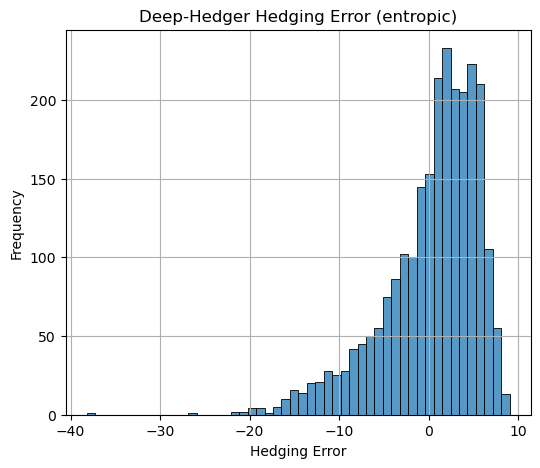

Running Deep Hedger with ENTROPIC loss, gamma=0.1
Mean hedging error: 0.20883184051521725
Std of hedging error: 4.2284072543289986


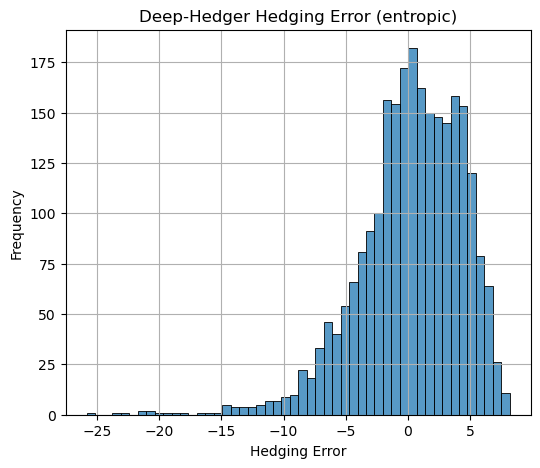

Running Deep Hedger with ENTROPIC loss, gamma=1
Mean hedging error: 0.21741021473940336
Std of hedging error: 4.823201567920226


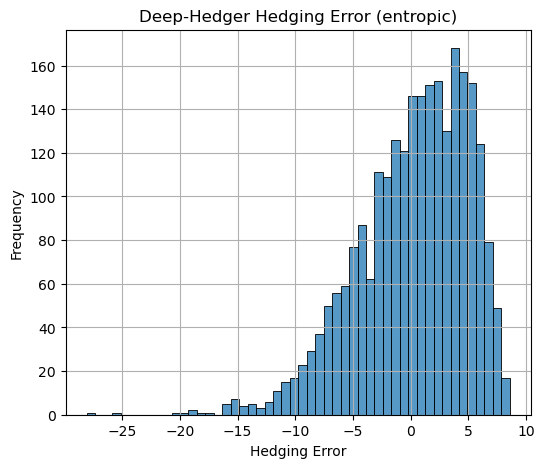

Running Deep Hedger with ENTROPIC loss, gamma=10
Mean hedging error: 0.19804957019565209
Std of hedging error: 4.7219088859022165


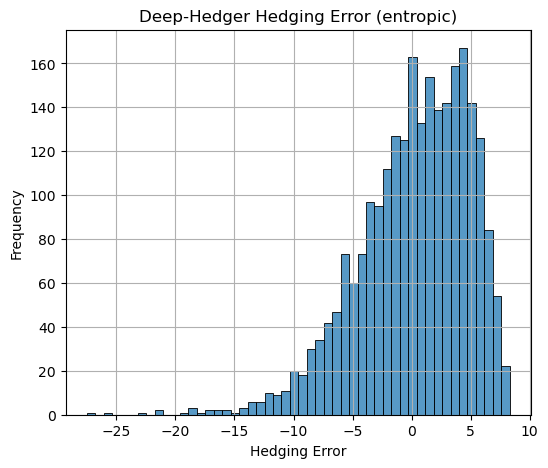

Running Deep Hedger with ENTROPIC loss, gamma=100
Mean hedging error: 0.20628143794774093
Std of hedging error: 4.6647813490481385


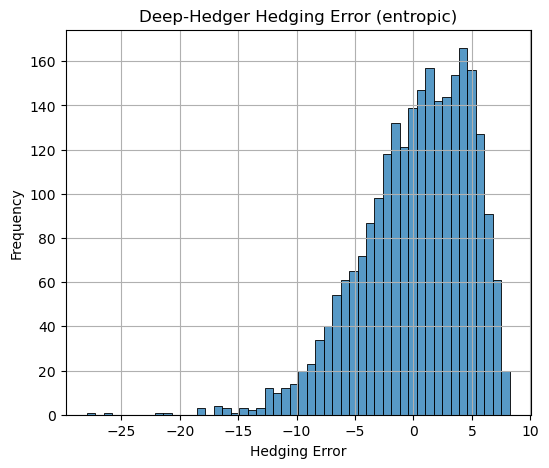

In [53]:
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt

gammas = [0.001,0.01,0.1,1,10,100]
results = []

model = RoughBergomiModel()

hidden_size = 64
n_layers = 1
optimizer = 'adam'

for gamma in gammas:
    print(f"Running Deep Hedger with ENTROPIC loss, gamma={gamma}")

    dh = DeepHedgerTF(
        model=model,
        M=2500,
        N=100,
        T=1
    )

    dh.prepare_data()

    dh.build_and_compile_model(
        lr=0.001,
        loss_type='entropic',
        gru_layers=n_layers,
        hidden_size=hidden_size,
        optimizer=optimizer,
        gamma=gamma
    )

    dh.train_model(epochs=30, batch_size=256)

    hedging_error = dh.evaluate_model()
    dh.plot_error(loss_type='entropic')

    # Statistical metrics
    mean_error = np.mean(hedging_error)
    std_error = np.std(hedging_error)
    cvar_1_error = np.mean(np.sort(hedging_error)[:int(0.01 * len(hedging_error))])
    cvar_5_error = np.mean(np.sort(hedging_error)[:int(0.05 * len(hedging_error))])
    cvar_10_error = np.mean(np.sort(hedging_error)[:int(0.1 * len(hedging_error))])
    skew_error = skew(hedging_error)
    kurt_error = kurtosis(hedging_error, fisher=True)  # Excess kurtosis

    results.append((gamma, mean_error, std_error, cvar_1_error, cvar_5_error, cvar_10_error, skew_error, kurt_error))



In [54]:
for gamma, mean_e, std_e, cvar_1, cvar_5, cvar_10, skew_e, kurt_e in results:
    print(f"gamma = {gamma} | Mean: {mean_e:.4f} | Std: {std_e:.4f} | "
          f"CVaR@1%: {cvar_1:.4f} | CVaR@5%: {cvar_5:.4f} | CVaR@10%: {cvar_10:.4f} | "
          f"Skew: {skew_e:.4f} | Kurtosis: {kurt_e:.4f}")

gamma = 0.001 | Mean: 2.9486 | Std: 49.7410 | CVaR@1%: -177.2078 | CVaR@5%: -119.5298 | CVaR@10%: -91.7443 | Skew: 1.3927 | Kurtosis: 22.4213
gamma = 0.01 | Mean: 0.2700 | Std: 5.3951 | CVaR@1%: -19.4041 | CVaR@5%: -14.3314 | CVaR@10%: -11.6282 | Skew: -1.2714 | Kurtosis: 2.1645
gamma = 0.1 | Mean: 0.2088 | Std: 4.2284 | CVaR@1%: -17.4411 | CVaR@5%: -10.7231 | CVaR@10%: -8.3859 | Skew: -1.1300 | Kurtosis: 2.8966
gamma = 1 | Mean: 0.2174 | Std: 4.8232 | CVaR@1%: -17.0702 | CVaR@5%: -11.6226 | CVaR@10%: -9.4531 | Skew: -0.8781 | Kurtosis: 1.1139
gamma = 10 | Mean: 0.1980 | Std: 4.7219 | CVaR@1%: -17.4200 | CVaR@5%: -11.5498 | CVaR@10%: -9.3116 | Skew: -0.9448 | Kurtosis: 1.5349
gamma = 100 | Mean: 0.2063 | Std: 4.6648 | CVaR@1%: -16.6576 | CVaR@5%: -11.2872 | CVaR@10%: -9.1451 | Skew: -0.8974 | Kurtosis: 1.3298


In [58]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(results, columns=[
    "Gamma", "Mean", "Std", "CVaR@1%", "CVaR@5%", "CVaR@10%", "Skew", "Kurtosis"
])


df = df[["Gamma", "Mean", "Std", "CVaR@1%", "CVaR@5%", "CVaR@10%", "Skew", "Kurtosis"]]

# Round to 4 decimal places
df = df.round(4)
df["Gamma"] = df["Gamma"].apply(lambda x: f"{x:.3f}" if x < 1 else f"{int(x)}")
# Output as LaTeX table
latex_table = df.to_latex(index=False, caption="Summary Table with CVaR at 5\\% and 10\\%", label="tab:cvar_summary")

print(latex_table)

\begin{table}
\caption{Summary Table with CVaR at 5\% and 10\%}
\label{tab:cvar_summary}
\begin{tabular}{lrrrrrrr}
\toprule
Gamma & Mean & Std & CVaR@1% & CVaR@5% & CVaR@10% & Skew & Kurtosis \\
\midrule
0.001 & 2.948600 & 49.741000 & -177.207800 & -119.529800 & -91.744300 & 1.392700 & 22.421300 \\
0.010 & 0.270000 & 5.395100 & -19.404100 & -14.331400 & -11.628200 & -1.271400 & 2.164500 \\
0.100 & 0.208800 & 4.228400 & -17.441100 & -10.723100 & -8.385900 & -1.130000 & 2.896600 \\
1 & 0.217400 & 4.823200 & -17.070200 & -11.622600 & -9.453100 & -0.878100 & 1.113900 \\
10 & 0.198000 & 4.721900 & -17.420000 & -11.549800 & -9.311600 & -0.944800 & 1.534900 \\
100 & 0.206300 & 4.664800 & -16.657600 & -11.287200 & -9.145100 & -0.897400 & 1.329800 \\
\bottomrule
\end{tabular}
\end{table}



Running Deep Hedger with loss: CVAR1%
Mean hedging error: -6.630814269692564e-06
Std of hedging error: 4.61190968967784


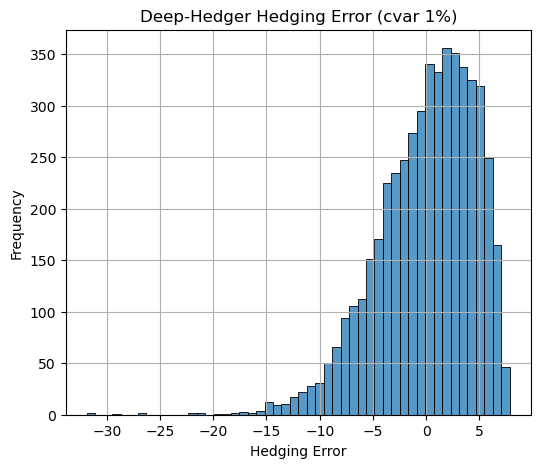

Running Deep Hedger with loss: CVAR5%
Mean hedging error: -0.006540983921550901
Std of hedging error: 4.252891518256097


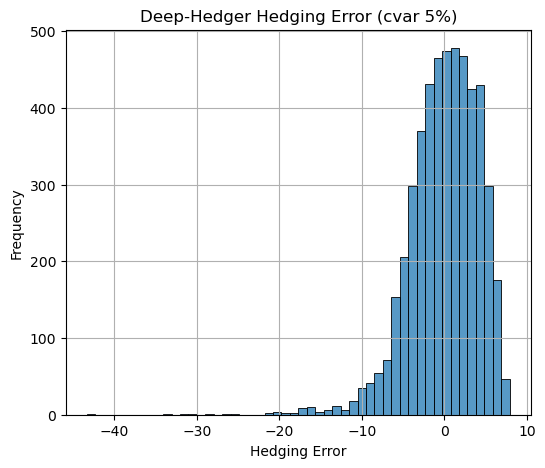

Running Deep Hedger with loss: CVAR10%
Mean hedging error: -0.009557730674699193
Std of hedging error: 4.103276339792957


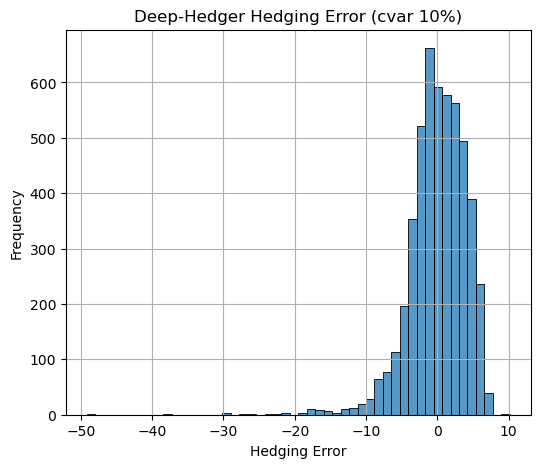

In [43]:
model = RoughBergomiModel()
results = []

hidden_size = 64
n_layers = 1
optimizer = 'adam'
loss = 'cvar'

for p in [0.01, 0.05, 0.1]:
    print(f"Running Deep Hedger with loss: {loss.upper()}{p*100:.0f}%")

    dh = DeepHedgerTF(
        model=model,
        M=5000,
        N=100,
        T=1
    )

    dh.prepare_data()

    dh.build_and_compile_model(
        lr=0.001,
        loss_type=loss,
        gru_layers=n_layers,
        hidden_size=hidden_size,
        optimizer=optimizer,
        proportion=p
    )

    dh.train_model(epochs=30, batch_size=256)

    hedging_error = dh.evaluate_model()

    # Plot error distribution
    dh.plot_error(loss_type = loss, proportion=p)
    dh.plot_pnl()

        # Statistical metrics
    mean_error = np.mean(hedging_error)
    std_error = np.std(hedging_error)
    cvar_1_error = np.mean(np.sort(hedging_error)[:int(0.01 * len(hedging_error))])
    cvar_5_error = np.mean(np.sort(hedging_error)[:int(0.05 * len(hedging_error))])
    cvar_10_error = np.mean(np.sort(hedging_error)[:int(0.1 * len(hedging_error))])
    skew_error = skew(hedging_error)
    kurt_error = kurtosis(hedging_error, fisher=True)  # Excess kurtosis

    results.append((loss, p, mean_error, std_error, cvar_1_error, cvar_5_error, cvar_10_error, skew_error, kurt_error))

In [44]:
# Updated summary table with CVaR at 5% and 10%
for loss, p, mean_e, std_e, cvar_1, cvar_5, cvar_10, skew_e, kurt_e in results:
    print(f"{loss.upper()}{p*100:.0f}% | Mean: {mean_e:.4f} | Std: {std_e:.4f} | "
          f"CVaR@1%: {cvar_1:.4f} | CVaR@5%: {cvar_5:.4f} | CVaR@10%: {cvar_10:.4f} | "
          f"Skew: {skew_e:.4f} | Kurtosis: {kurt_e:.4f}")

CVAR1% | Mean: -0.0000 | Std: 4.6119 | CVaR@1%: -16.9863 | CVaR@5%: -11.3650 | CVaR@10%: -9.2610 | Skew: -0.9776 | Kurtosis: 1.9908
CVAR5% | Mean: -0.0065 | Std: 4.2529 | CVaR@1%: -18.6432 | CVaR@5%: -10.8566 | CVaR@10%: -8.3366 | Skew: -1.3571 | Kurtosis: 5.9459
CVAR10% | Mean: -0.0096 | Std: 4.1033 | CVaR@1%: -19.7231 | CVaR@5%: -10.9018 | CVaR@10%: -8.1266 | Skew: -1.8383 | Kurtosis: 10.8779


In [ ]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(results, columns=[
    "Loss", "p", "Mean", "Std", "CVaR@1%", "CVaR@5%", "CVaR@10%", "Skew", "Kurtosis"
])

# Format 'Loss' column with percentage
df["Loss @ p%"] = df.apply(lambda row: f"{row['Loss'].upper()}{int(row['p'] * 100)}%", axis=1)
df = df[["Loss @ p%", "Mean", "Std", "CVaR@1%", "CVaR@5%", "CVaR@10%", "Skew", "Kurtosis"]]

# Round to 4 decimal places
df = df.round(4)

# Output as LaTeX table
latex_table = df.to_latex(index=False, caption="Summary Table with CVaR at 5\\% and 10\\%", label="tab:cvar_summary")

print(latex_table)

\begin{table}
\caption{Summary Table with CVaR at 5\% and 10\%}
\label{tab:cvar_summary}
\begin{tabular}{lrrrrrrr}
\toprule
Loss @ p% & Mean & Std & CVaR@1% & CVaR@5% & CVaR@10% & Skew & Kurtosis \\
\midrule
CVAR1% & -0.000000 & 4.611900 & -16.986300 & -11.365000 & -9.261000 & -0.977600 & 1.990800 \\
CVAR5% & -0.006500 & 4.252900 & -18.643200 & -10.856600 & -8.336600 & -1.357100 & 5.945900 \\
CVAR10% & -0.009600 & 4.103300 & -19.723100 & -10.901800 & -8.126600 & -1.838300 & 10.877900 \\
\bottomrule
\end{tabular}
\end{table}



Running Deep Hedger with loss: MSHE
Mean hedging error: -0.009974103038028155
Std of hedging error: 4.00007707291707


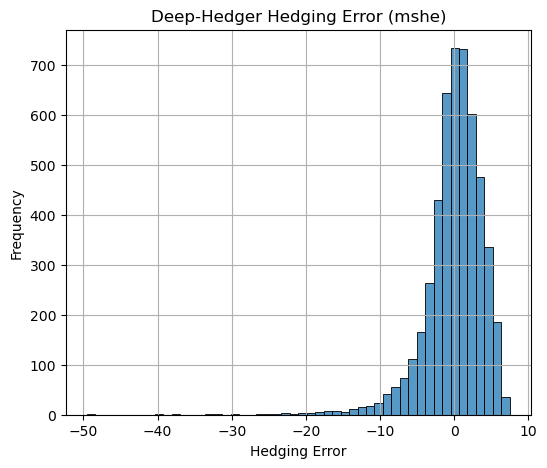

In [38]:
model = RoughBergomiModel()
results = []

hidden_size = 64
n_layers = 1
optimizer = 'adam'
loss_types = ['mshe']

for loss in loss_types:
    print(f"Running Deep Hedger with loss: {loss.upper()}")

    dh = DeepHedgerTF(
        model=model,
        M=5000,
        N=100,
        T=1
    )

    dh.prepare_data()
    gamma = 10 if loss == 'entropic' else None

    dh.build_and_compile_model(
        lr=0.001,
        loss_type=loss,
        gru_layers=n_layers,
        hidden_size=hidden_size,
        optimizer=optimizer,
        gamma=gamma
    )

    dh.train_model(epochs=30, batch_size=256)

    hedging_error = dh.evaluate_model()

    # Plot error distribution
    dh.plot_error(loss_type = loss)
    dh.plot_pnl()

        # Statistical metrics
    mean_error = np.mean(hedging_error)
    std_error = np.std(hedging_error)
    cvar_1_error = np.mean(np.sort(hedging_error)[:int(0.01 * len(hedging_error))])
    cvar_5_error = np.mean(np.sort(hedging_error)[:int(0.05 * len(hedging_error))])
    cvar_10_error = np.mean(np.sort(hedging_error)[:int(0.1 * len(hedging_error))])
    skew_error = skew(hedging_error)
    kurt_error = kurtosis(hedging_error, fisher=True)  # Excess kurtosis

    results.append((loss, mean_error, std_error, cvar_1_error, cvar_5_error, cvar_10_error, skew_error, kurt_error))

In [40]:
import pandas as pd

# Sample data structure
# results = [
#     (loss, p, mean_e, std_e, cvar_1, cvar_5, cvar_10, skew_e, kurt_e),
#     ...
# ]

# Convert to DataFrame
df = pd.DataFrame(results, columns=[
    "Loss", "Mean", "Std", "CVaR@1%", "CVaR@5%", "CVaR@10%", "Skew", "Kurtosis"
])

# Format 'Loss' column with percentage
df["Loss"] = df.apply(lambda row: f"{row['Loss'].upper()}", axis=1)
df = df[["Loss", "Mean", "Std", "CVaR@1%", "CVaR@5%", "CVaR@10%", "Skew", "Kurtosis"]]

# Round to 4 decimal places
df = df.round(4)

# Output as LaTeX table
latex_table = df.to_latex(index=False, caption="Summary Table with CVaR at 5\\% and 10\\%", label="tab:cvar_summary")

print(latex_table)

\begin{table}
\caption{Summary Table with CVaR at 5\% and 10\%}
\label{tab:cvar_summary}
\begin{tabular}{lrrrrrrr}
\toprule
Loss & Mean & Std & CVaR@1% & CVaR@5% & CVaR@10% & Skew & Kurtosis \\
\midrule
MSHE & -0.010000 & 4.000100 & -20.401300 & -11.389900 & -8.367400 & -2.319600 & 14.085500 \\
\bottomrule
\end{tabular}
\end{table}

